In [1]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random

C:\Users\Elisa Valente\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Elisa Valente\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Elisa Valente\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

### Load data and define the dataset name

In [2]:
Bot = pd.read_csv('GAN_generation/Bot_Attack_Data_for_GAN.csv', sep=',')
Bot.name = 'Bot'


BF_SSH_Patator = pd.read_csv('GAN_generation/Brute_Force_SSH_Patator_Data.csv', sep=',')
BF_SSH_Patator.name = 'BF_SSH_Patator'

BF_FTP_Patator = pd.read_csv('GAN_generation/Brute_Force_FTP_Patator_Data.csv', sep=',')
BF_FTP_Patator.name = 'BF_FTP_Patator'


WA_Brute_Force = pd.read_csv('GAN_generation/Web_Attack_Brute_Force_Data.csv', sep=',')
WA_Brute_Force.name = 'WA_Brute_Force'

WA_XSS = pd.read_csv('GAN_generation/Web_Attack_XSS_Data.csv', sep=',')
WA_XSS.name = 'WA_XSS'


DoS_GoldenEye = pd.read_csv('GAN_generation/Dos_GoldenEye_Data.csv', sep=',')
DoS_GoldenEye.name = 'DoS_GoldenEye'

DoS_Hulk = pd.read_csv('GAN_generation/DoS_Hulk_Data.csv', sep=',')
DoS_Hulk.name = 'DoS_Hulk'

DoS_Slowhttptest = pd.read_csv('GAN_generation/DoS_Slowhttptest_Data.csv', sep=',')
DoS_Slowhttptest.name = 'DoS_Slowhttptest'

DoS_Slowlori = pd.read_csv('GAN_generation/DoS_Slowlori_Data.csv', sep=',')
DoS_Slowlori.name = 'DoS_Slowlori'

### Amount of data needed to generate for each label

In [3]:
Bot_generate = 83316

BF_SSH_Patator_generate = 181899

BF_FTP_Patator_generate = 180881

WA_Brute_Force_generate = 71153

WA_XSS_generate = 71581

DoS_GoldenEye_generate = 187210

DoS_Hulk_generate = 83911

DoS_Slowhttptest_generate = 189604

DoS_Slowlori_generate = 189469

### Model Inputs

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")

    return inputs_real, inputs_z

### Generator 

In [5]:
def generator(z, out_dim, n_units=64, reuse=False,  alpha=0.01):

    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)

        #ReLU
        h1 = tf.maximum(0.0, h1)

        h2  = tf.layers.dense(h1, n_units, activation=None)

        h2 = tf.maximum(0.0, h2)

        h3  = tf.layers.dense(h2, n_units, activation=None)

        h3 = tf.maximum(0.0, h3)
        # Logits and sigmoid output
        logits = tf.layers.dense(h3, out_dim, activation=None)
        
        out = tf.nn.sigmoid(logits)

        return out, logits

### Discriminator

In [6]:
def discriminator(x, n_units=64, reuse=False, alpha=0.01):

    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)

        h2  = tf.layers.dense(h1, n_units, activation=None)

        h2 = tf.maximum(h2, alpha*h2)

        logits = tf.layers.dense(h2, 1, activation=None)
        
        out = tf.maximum(logits, alpha*logits)
                
        return out, logits

### Hyperparameters 

In [28]:
# Select the dataset to use and the amount to generate
DATASET = DoS_Slowlori
AMOUNT_TO_GENERATE = DoS_Slowlori_generate

# Network Hyperparameters
INPUT_SIZE = len(DATASET.columns)  
# Size of latent vector to generator
Z_SIZE = 70 
G_HIDDEN_SIZE = 64
D_HIDDEN_SIZE = 64
ALPHA = 0.02

# Gradient penalty hyperparameters
LAMBDA = 10 
D_LR = 0.0005
G_LR = 0.0005
BETA1_D = 0.0
BETA1_G = 0.0

# Training parameters
BATCH_SIZE=100 #DoS_HULK 10 000
EPOCHS = 101 #101

### Building the Network

In [29]:
tf.reset_default_graph()
# Create the input placeholders
input_real, input_z = model_inputs(INPUT_SIZE, Z_SIZE)

# Generator network
g_model, g_logits = generator(input_z, INPUT_SIZE, G_HIDDEN_SIZE, reuse=False,  alpha=ALPHA)

# Disriminator network
d_model_real, d_logits_real = discriminator(input_real, D_HIDDEN_SIZE, reuse=False, alpha=ALPHA)
d_model_fake, d_logits_fake = discriminator(g_model, D_HIDDEN_SIZE, reuse=True, alpha=ALPHA)


### Training losses

In [30]:
# Generator
g_loss = -tf.reduce_mean(d_model_fake)

# Discriminator
d_loss = tf.reduce_mean(d_model_fake) - tf.reduce_mean(d_model_real)

alpha = tf.random_uniform(shape=[BATCH_SIZE,1],minval=0.,maxval=1.)

differences = g_model - input_real
interpolates = input_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates, reuse=True), interpolates)[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
d_loss += LAMBDA*gradient_penalty

### Optimizer

In [31]:
# Split the trainable_variables into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

# Optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=BETA1_G, beta2=0.9).minimize(d_loss, var_list=d_vars, colocate_gradients_with_ops=True)
g_train_opt = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=BETA1_D, beta2=0.9).minimize(g_loss, var_list=g_vars, colocate_gradients_with_ops=True)

### Training

In [32]:
# Select the dataset to train
index = DATASET.index
number_of_rows = len(index)

samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(EPOCHS):
        for ii in range(number_of_rows//BATCH_SIZE):

            data = DATASET.sample(BATCH_SIZE) 
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_SIZE))

            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: data, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

        # At each 100 epochs, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: data})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        if e%100 == 0:
            print("Epoch {}/{}...".format(e+1, EPOCHS),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))

        if e==(EPOCHS-1):
            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(AMOUNT_TO_GENERATE, Z_SIZE))
            gen_samples = sess.run(
                           generator(input_z, INPUT_SIZE, reuse=True),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples)
            saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/101... Discriminator Loss: -1.3852... Generator Loss: -0.3958
Epoch 101/101... Discriminator Loss: 8830.5107... Generator Loss: 0.4191


### Losses graphic

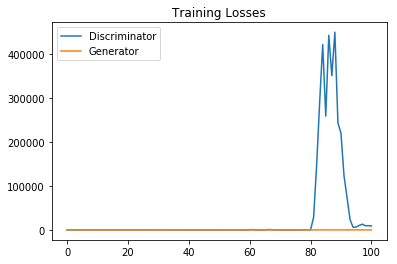

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Save the generated data to a csv file 

In [34]:
samples[0] #= (out, logists)
output, generated_data = samples[0]
generated_data.shape

file_name = "GAN_generation/GAN_Generated_Data/WGAN_GP_generated_"+DATASET.name+".csv"

# Save training generator samples
np.savetxt(file_name,output,delimiter=",")